In [9]:
#!/usr/bin/env python3
"""KOSPI200(코스피200) 기반 선물/옵션의 투자자별 포지션(외국인/기관) 시각화 스크립트.

사용 예시:
    python plot_kospi200_derivatives_positions.py --input-csv krx_positions.csv
    python plot_kospi200_derivatives_positions.py --input-csv krx_positions.csv --expiry 202603 --show

노트북/IPython에서 실행 시에는 --input-csv를 생략하면
동일 폴더의 sample_krx_positions.csv를 기본값으로 사용합니다.

입력 CSV는 KRX에서 내려받은 "투자자별 포지션" 유형 파일을 가정하며,
컬럼명이 조금 달라도 후보군에서 자동으로 찾아 처리합니다.
"""

from __future__ import annotations

import argparse
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import pandas as pd


EXPIRY_DEFAULT = "202603"  # 2026년 3월 만기
DEFAULT_INPUT_CSV = Path("sample_krx_positions.csv")


def configure_korean_font() -> str:
    """그래프에서 한글 깨짐을 방지하기 위해 사용 가능한 한글 폰트를 설정."""
    candidates = [
        "Malgun Gothic",
        "AppleGothic",
        "NanumGothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "Arial Unicode MS",
    ]

    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            rcParams["font.family"] = name
            rcParams["axes.unicode_minus"] = False
            return name

    # 후보군이 없으면 기본 폰트 유지 (환경별로 다름)
    rcParams["axes.unicode_minus"] = False
    return "default"


def _pick_column(df: pd.DataFrame, candidates: Iterable[str], col_type: str) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"{col_type} 컬럼을 찾지 못했습니다. 현재 컬럼: {list(df.columns)}")


def _normalize_expiry(value: str) -> str:
    s = str(value).strip()
    digits = "".join(ch for ch in s if ch.isdigit())
    if len(digits) >= 6:
        return digits[:6]
    return s


def _normalize_instrument(value: str) -> str | None:
    s = str(value)
    if "선물" in s:
        return "선물"
    if "옵션" in s or "콜" in s or "풋" in s:
        return "옵션"
    return None


def _normalize_investor(value: str) -> str | None:
    s = str(value)
    if "외국" in s:
        return "외국인"
    if "기관" in s:
        return "기관"
    return None


def load_and_transform(csv_path: Path, expiry: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, encoding="utf-8-sig")

    expiry_col = _pick_column(df, ["만기월", "만기", "결제월", "월물"], "만기")
    instrument_col = _pick_column(df, ["상품구분", "상품", "종목명", "구분"], "상품")
    investor_col = _pick_column(df, ["투자자", "투자자구분", "투자자별", "회원구분"], "투자자")

    long_col = _pick_column(
        df,
        ["매수포지션", "매수", "롱포지션", "잔고매수수량", "매수수량"],
        "매수포지션",
    )
    short_col = _pick_column(
        df,
        ["매도포지션", "매도", "숏포지션", "잔고매도수량", "매도수량"],
        "매도포지션",
    )

    work = df.copy()
    work["_expiry"] = work[expiry_col].map(_normalize_expiry)
    work["_instrument"] = work[instrument_col].map(_normalize_instrument)
    work["_investor"] = work[investor_col].map(_normalize_investor)

    target_expiry = _normalize_expiry(expiry)
    work = work[work["_expiry"] == target_expiry]
    work = work[work["_instrument"].notna() & work["_investor"].notna()]

    if work.empty:
        raise ValueError(
            f"{target_expiry} 만기(2026-03) 데이터가 없거나 컬럼 매핑에 실패했습니다."
        )

    work[long_col] = pd.to_numeric(work[long_col], errors="coerce").fillna(0)
    work[short_col] = pd.to_numeric(work[short_col], errors="coerce").fillna(0)
    work["순포지션"] = work[long_col] - work[short_col]

    agg = (
        work.groupby(["_instrument", "_investor"], as_index=False)["순포지션"]
        .sum()
        .rename(columns={"_instrument": "상품", "_investor": "투자자"})
    )

    # 보기 좋게 정렬
    order_inst = {"선물": 0, "옵션": 1}
    order_inv = {"외국인": 0, "기관": 1}
    agg["_o1"] = agg["상품"].map(order_inst)
    agg["_o2"] = agg["투자자"].map(order_inv)
    agg = agg.sort_values(["_o1", "_o2"]).drop(columns=["_o1", "_o2"])

    return agg


def plot_positions(agg: pd.DataFrame, expiry: str, output_path: Path, show: bool) -> None:
    pivot = agg.pivot(index="상품", columns="투자자", values="순포지션").fillna(0)

    for col in ["외국인", "기관"]:
        if col not in pivot.columns:
            pivot[col] = 0

    pivot = pivot[["외국인", "기관"]]

    ax = pivot.plot(kind="bar", figsize=(8, 5), rot=0)
    ax.axhline(0, color="black", linewidth=1)
    ax.set_title(f"KOSPI200 선물/옵션 {expiry} 만기 투자자 순포지션")
    ax.set_ylabel("순포지션 (매수-매도)")
    ax.set_xlabel("상품")
    ax.legend(title="투자자")

    for p in ax.patches:
        h = p.get_height()
        ax.annotate(
            f"{h:,.0f}",
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom" if h >= 0 else "top",
            fontsize=9,
            xytext=(0, 3 if h >= 0 else -3),
            textcoords="offset points",
        )

    plt.tight_layout()
    output_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_path, dpi=150)

    if show:
        plt.show()
    plt.close()


def main() -> None:
    selected_font = configure_korean_font()

    parser = argparse.ArgumentParser(
        description="KOSPI200 2026년 3월 만기 선물/옵션 외국인·기관 포지션 그래프 생성"
    )
    parser.add_argument(
        "--input-csv",
        type=Path,
        default=None,
        help=(
            "KRX 투자자별 포지션 CSV 파일. 미지정 시 sample_krx_positions.csv를 자동 사용"
        ),
    )
    parser.add_argument("--expiry", default=EXPIRY_DEFAULT, help="만기월(예: 202603 또는 2026-03)")
    parser.add_argument(
        "--output", type=Path, default=Path("output/kospi200_positions_202603.png"), help="출력 이미지 파일 경로"
    )
    parser.add_argument("--show", action="store_true", help="그래프 창 표시")
    # Jupyter/ipykernel이 전달하는 알 수 없는 인자는 무시
    args, _unknown = parser.parse_known_args()

    input_csv = args.input_csv
    if input_csv is None:
        if DEFAULT_INPUT_CSV.exists():
            input_csv = DEFAULT_INPUT_CSV
            print(f"--input-csv 미지정: 기본 샘플 파일 사용 -> {input_csv}")
        else:
            parser.error(
                "--input-csv가 필요합니다. 또는 sample_krx_positions.csv 파일을 현재 폴더에 두세요."
            )

    agg = load_and_transform(input_csv, args.expiry)
    plot_positions(agg, _normalize_expiry(args.expiry), args.output, args.show)

    print(f"사용 폰트: {selected_font}")
    print("집계 결과:")
    print(agg.to_string(index=False))
    print(f"\n그래프 저장 완료: {args.output}")


if __name__ == "__main__":
    main()

--input-csv 미지정: 기본 샘플 파일 사용 -> sample_krx_positions.csv
사용 폰트: Malgun Gothic
집계 결과:
상품 투자자   순포지션
선물 외국인  30000
선물  기관 -15000
옵션 외국인  30000
옵션  기관      0

그래프 저장 완료: output\kospi200_positions_202603.png


--input-csv 미지정: 기본 샘플 파일 사용 -> sample_krx_positions.csv


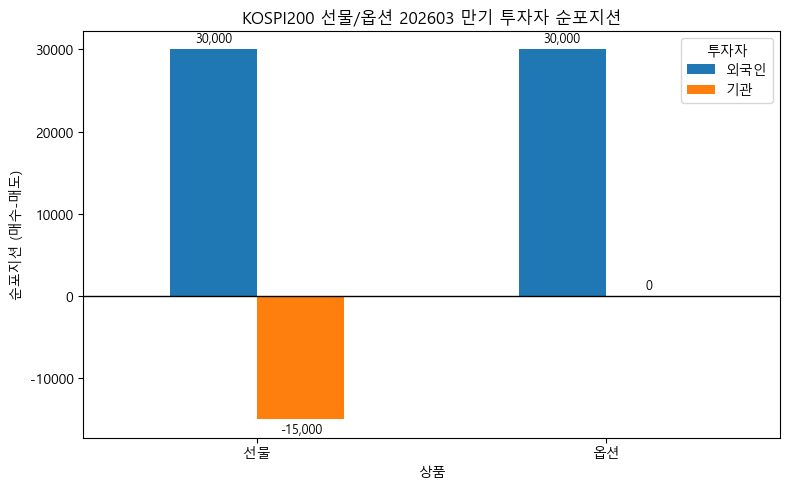

사용 폰트: Malgun Gothic
집계 결과:
상품 투자자   순포지션
선물 외국인  30000
선물  기관 -15000
옵션 외국인  30000
옵션  기관      0

그래프를 화면에 표시했습니다. (파일 저장 안 함)


In [10]:
#!/usr/bin/env python3
"""KOSPI200(코스피200) 기반 선물/옵션의 투자자별 포지션(외국인/기관) 시각화 스크립트.

사용 예시:
    python plot_kospi200_derivatives_positions.py --input-csv krx_positions.csv
    python plot_kospi200_derivatives_positions.py --input-csv krx_positions.csv --expiry 202603
    python plot_kospi200_derivatives_positions.py --input-csv krx_positions.csv --output output/kospi200.png --no-show

노트북/IPython에서 실행 시에는 --input-csv를 생략하면
동일 폴더의 sample_krx_positions.csv를 기본값으로 사용합니다.

입력 CSV는 KRX에서 내려받은 "투자자별 포지션" 유형 파일을 가정하며,
컬럼명이 조금 달라도 후보군에서 자동으로 찾아 처리합니다.
"""

from __future__ import annotations

import argparse
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import pandas as pd


EXPIRY_DEFAULT = "202603"  # 2026년 3월 만기
DEFAULT_INPUT_CSV = Path("sample_krx_positions.csv")


def configure_korean_font() -> str:
    """그래프에서 한글 깨짐을 방지하기 위해 사용 가능한 한글 폰트를 설정."""
    candidates = [
        "Malgun Gothic",
        "AppleGothic",
        "NanumGothic",
        "Noto Sans CJK KR",
        "Noto Sans KR",
        "Arial Unicode MS",
    ]

    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            rcParams["font.family"] = name
            rcParams["axes.unicode_minus"] = False
            return name

    # 후보군이 없으면 기본 폰트 유지 (환경별로 다름)
    rcParams["axes.unicode_minus"] = False
    return "default"


def _pick_column(df: pd.DataFrame, candidates: Iterable[str], col_type: str) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"{col_type} 컬럼을 찾지 못했습니다. 현재 컬럼: {list(df.columns)}")


def _normalize_expiry(value: str) -> str:
    s = str(value).strip()
    digits = "".join(ch for ch in s if ch.isdigit())
    if len(digits) >= 6:
        return digits[:6]
    return s


def _normalize_instrument(value: str) -> str | None:
    s = str(value)
    if "선물" in s:
        return "선물"
    if "옵션" in s or "콜" in s or "풋" in s:
        return "옵션"
    return None


def _normalize_investor(value: str) -> str | None:
    s = str(value)
    if "외국" in s:
        return "외국인"
    if "기관" in s:
        return "기관"
    return None


def load_and_transform(csv_path: Path, expiry: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, encoding="utf-8-sig")

    expiry_col = _pick_column(df, ["만기월", "만기", "결제월", "월물"], "만기")
    instrument_col = _pick_column(df, ["상품구분", "상품", "종목명", "구분"], "상품")
    investor_col = _pick_column(df, ["투자자", "투자자구분", "투자자별", "회원구분"], "투자자")

    long_col = _pick_column(
        df,
        ["매수포지션", "매수", "롱포지션", "잔고매수수량", "매수수량"],
        "매수포지션",
    )
    short_col = _pick_column(
        df,
        ["매도포지션", "매도", "숏포지션", "잔고매도수량", "매도수량"],
        "매도포지션",
    )

    work = df.copy()
    work["_expiry"] = work[expiry_col].map(_normalize_expiry)
    work["_instrument"] = work[instrument_col].map(_normalize_instrument)
    work["_investor"] = work[investor_col].map(_normalize_investor)

    target_expiry = _normalize_expiry(expiry)
    work = work[work["_expiry"] == target_expiry]
    work = work[work["_instrument"].notna() & work["_investor"].notna()]

    if work.empty:
        raise ValueError(
            f"{target_expiry} 만기(2026-03) 데이터가 없거나 컬럼 매핑에 실패했습니다."
        )

    work[long_col] = pd.to_numeric(work[long_col], errors="coerce").fillna(0)
    work[short_col] = pd.to_numeric(work[short_col], errors="coerce").fillna(0)
    work["순포지션"] = work[long_col] - work[short_col]

    agg = (
        work.groupby(["_instrument", "_investor"], as_index=False)["순포지션"]
        .sum()
        .rename(columns={"_instrument": "상품", "_investor": "투자자"})
    )

    # 보기 좋게 정렬
    order_inst = {"선물": 0, "옵션": 1}
    order_inv = {"외국인": 0, "기관": 1}
    agg["_o1"] = agg["상품"].map(order_inst)
    agg["_o2"] = agg["투자자"].map(order_inv)
    agg = agg.sort_values(["_o1", "_o2"]).drop(columns=["_o1", "_o2"])

    return agg


def plot_positions(agg: pd.DataFrame, expiry: str, output_path: Path | None, show: bool) -> None:
    pivot = agg.pivot(index="상품", columns="투자자", values="순포지션").fillna(0)

    for col in ["외국인", "기관"]:
        if col not in pivot.columns:
            pivot[col] = 0

    pivot = pivot[["외국인", "기관"]]

    ax = pivot.plot(kind="bar", figsize=(8, 5), rot=0)
    ax.axhline(0, color="black", linewidth=1)
    ax.set_title(f"KOSPI200 선물/옵션 {expiry} 만기 투자자 순포지션")
    ax.set_ylabel("순포지션 (매수-매도)")
    ax.set_xlabel("상품")
    ax.legend(title="투자자")

    for p in ax.patches:
        h = p.get_height()
        ax.annotate(
            f"{h:,.0f}",
            (p.get_x() + p.get_width() / 2, h),
            ha="center",
            va="bottom" if h >= 0 else "top",
            fontsize=9,
            xytext=(0, 3 if h >= 0 else -3),
            textcoords="offset points",
        )

    plt.tight_layout()

    if output_path is not None:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path, dpi=150)

    if show:
        plt.show()
    plt.close()


def main() -> None:
    selected_font = configure_korean_font()

    parser = argparse.ArgumentParser(
        description="KOSPI200 2026년 3월 만기 선물/옵션 외국인·기관 포지션 그래프 생성"
    )
    parser.add_argument(
        "--input-csv",
        type=Path,
        default=None,
        help=(
            "KRX 투자자별 포지션 CSV 파일. 미지정 시 sample_krx_positions.csv를 자동 사용"
        ),
    )
    parser.add_argument("--expiry", default=EXPIRY_DEFAULT, help="만기월(예: 202603 또는 2026-03)")
    parser.add_argument(
        "--output",
        type=Path,
        default=None,
        help="이미지 저장 경로(미지정 시 파일 저장 안 함)",
    )
    parser.add_argument(
        "--no-show",
        action="store_true",
        help="그래프 창 표시를 끄고 실행(예: 서버/배치 환경)",
    )
    # Jupyter/ipykernel이 전달하는 알 수 없는 인자는 무시
    args, _unknown = parser.parse_known_args()

    input_csv = args.input_csv
    if input_csv is None:
        if DEFAULT_INPUT_CSV.exists():
            input_csv = DEFAULT_INPUT_CSV
            print(f"--input-csv 미지정: 기본 샘플 파일 사용 -> {input_csv}")
        else:
            parser.error(
                "--input-csv가 필요합니다. 또는 sample_krx_positions.csv 파일을 현재 폴더에 두세요."
            )

    agg = load_and_transform(input_csv, args.expiry)
    show = not args.no_show
    plot_positions(agg, _normalize_expiry(args.expiry), args.output, show)

    print(f"사용 폰트: {selected_font}")
    print("집계 결과:")
    print(agg.to_string(index=False))
    if args.output is not None:
        print(f"\n그래프 저장 완료: {args.output}")
    else:
        print("\n그래프를 화면에 표시했습니다. (파일 저장 안 함)")


if __name__ == "__main__":
    main()